In [23]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
from pmdarima import auto_arima, ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
def plot_model(train, test, predictions, title):

    plt.Figure(figsize=(10, 5))

    plt.plot(train, label = 'Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label='Predictions')

    plt.title(f'Train, Test and predictions with {title}')
    plt.legend()
    plt.show()

def get_metrics(test, predictions):
    
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mean_squared_error(test, predictions))
    mape = mean_absolute_percentage_error(test, predictions)

    return {'mae': mae, 'rmse': rmse, 'mape': mape}

In [6]:
df = pd.read_csv('daily_revenue.csv')

df.date = pd.to_datetime(df.date, format='%d/%m/%Y')
df.set_index('date', inplace=True)

df.revenue = df.revenue.str.replace(',', '').astype(float)
df.discount_rate = df.discount_rate.str.replace('%', '').astype(float)
df.coupon_rate = df.coupon_rate.str.replace('%', '').astype(float)


In [21]:
#Split

test_size = 30
y_train, y_test = df.iloc[:-test_size, 0], df.iloc[-test_size:, 0]
X_train, X_test = df.iloc[:-test_size, 1:], df.iloc[-test_size:, 1:]

## ARIMA

In [37]:
arima_model = auto_arima(y=y_train, seasonal=False)
arima_predictions = arima_model.predict(n_periods=test_size)

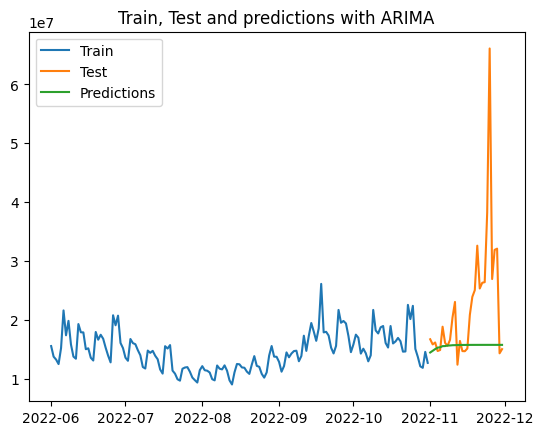

{'mae': 7267306.022951678,
 'rmse': 12366038.294324929,
 'mape': 0.2414611459322681}

In [49]:
plot_model(y_train.loc['2022-06':], y_test, arima_predictions, 'ARIMA')
get_metrics(y_test, arima_predictions)

## SARIMA

In [44]:
sarima_model = auto_arima(y=y_train, m=7)
sarima_predictions = sarima_model.predict(n_periods=test_size)

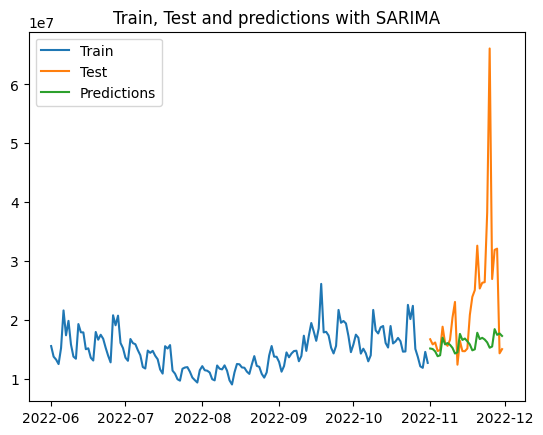

{'mae': 7210550.184536203,
 'rmse': 12152393.971280606,
 'mape': 0.24536524447189098}

In [50]:
plot_model(y_train.loc['2022-06':], y_test, sarima_predictions, 'SARIMA')
get_metrics(y_test, sarima_predictions)

### SARIMAX

In [46]:
sarimax_model = auto_arima(y=y_train, X=X_train, n=7)
sarimax_predictions = sarimax_model.predict(n_periods=test_size, X=X_test)

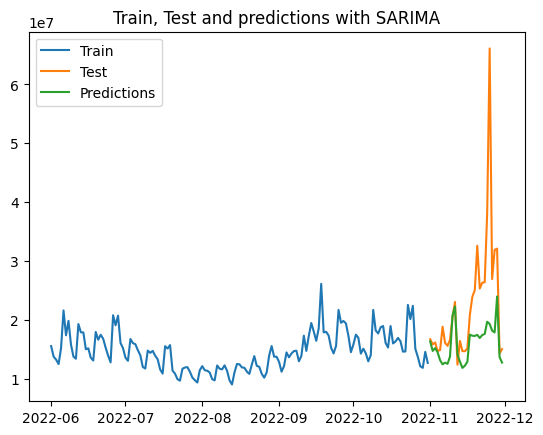

{'mae': 6405284.394535398,
 'rmse': 10897097.165185962,
 'mape': 0.2246128425859341}

In [48]:
plot_model(y_train.loc['2022-06':], y_test, sarimax_predictions, 'SARIMA')
get_metrics(y_test, sarimax_predictions)

### SARIMAX with Parameter Tuning

In [60]:
from sklearn.model_selection import ParameterGrid
from pmdarima import model_selection

In [98]:
param_grid = {'p': [1, 2, 3],
              'q': [1, 2],
              'P': [1, 2],
              'Q': [1, 2]}

grid = ParameterGrid(param_grid)

In [111]:
df.iloc[:,1:]

discount_rate  coupon_rate
date                                  
2018-01-01          34.27         1.09
2018-01-02          30.87         1.08
2018-01-03          28.11         1.01
2018-01-04          27.32         0.96
2018-01-05          25.70         0.90
...                   ...          ...
2022-11-26          30.41         0.38
2022-11-27          29.75         0.35
2022-11-28          25.27         8.93
2022-11-29          19.54         0.26
2022-11-30          17.10         0.32

[1795 rows x 2 columns]

In [112]:
rmse_list = []

for params in grid:

    model_cv = ARIMA(order=(params['p'], 0, params['q']),
                     season_order=(params['P'], 0, params['Q'], 7))
    
    cv=model_selection.RollingForecastCV(h=30, 
                                         step=15,
                                         initial=df.shape[0]-180)
    
    cv_score = model_selection.cross_val_score(model_cv, 
                                               y=df.revenue,
                                               X=df.iloc[:,1:],
                                               scoring='mean_squared_error',
                                               cv=cv,
                                               verbose=1,
                                               error_score=1e22)
    
    rmse_list.append(np.average(cv_score)**(1/2))

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packag

In [115]:
gridsearch_df = pd.DataFrame(grid)
gridsearch_df['rmse'] = rmse_list
gridsearch_df

gridsearch_df[gridsearch_df.rmse == gridsearch_df.rmse.min()]

P  Q  p  q          rmse
0   1  1  1  1  4.137492e+06
6   1  2  1  1  4.137492e+06
12  2  1  1  1  4.137492e+06
18  2  2  1  1  4.137492e+06

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


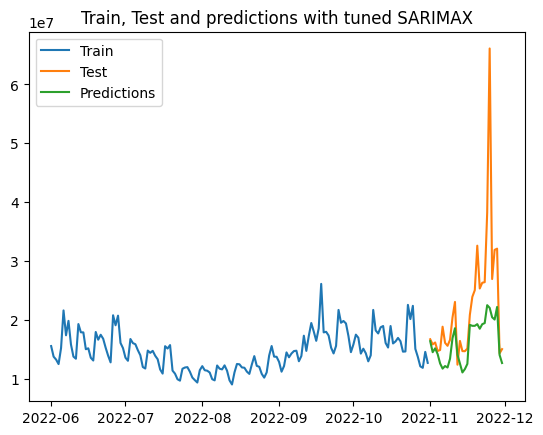

{'mae': 6124046.391221423,
 'rmse': 10066304.598308362,
 'mape': 0.2228103338635714}

In [116]:
p, d, q, P, D, Q = 1, 0, 2, 2, 0, 1

tuned_model = ARIMA(order=(p, d, q),
                season_order=(P, D, Q),
                m=7)

tuned_model.fit(y=y_train, X=X_train)
tuned_predictions = tuned_model.predict(X=X_test, n_periods=test_size)

plot_model(y_train.loc['2022-06':], y_test, tuned_predictions, 'tuned SARIMAX')
get_metrics(y_test, tuned_predictions)